# Exam: Exercise 6 - Dormand Prince 5(4)

### 6.1 Description and Stability

In [3]:
import numpy as np
import matplotlib.pyplot as plt

s, p = 7, 4 # stages s; order p

# Coefficients for Dormand-Prince method
c2, c3, c4, c5, c6, c7 = 1/5, 3/10, 4/5, 8/9, 1, 1
a21 = 1/5
a31, a32 = 3/40, 9/40
a41, a42, a43 = 44/45, -56/15, 32/9
a51, a52, a53, a54 = 19372/6561, -25360/2187, 64448/6561, -212/729
a61, a62, a63, a64, a65 = 9017/3168, -355/33, 46732/5247, 49/176, -5103/18656
a71, a72, a73, a74, a75, a76 = 35/384, 0, 500/1113, 125/192, -2187/6784, 11/84

b1, b2, b3, b4, b5, b6, b7 = 35/384, 0, 500/1113, 125/192, -2187/6784, 11/84, 0
b1p, b2p, b3p, b4p, b5p, b6p, b7p = 5179/57600, 0, 7571/16695, 393/640, -92097/339200, 187/2100, 1/40

# coefficient matrices and vectors
A = np.array([
    [0, 0, 0, 0, 0, 0, 0],
    [a21, 0, 0, 0, 0, 0, 0],
    [a31, a32, 0, 0, 0, 0, 0],
    [a41, a42, a43, 0, 0, 0, 0],
    [a51, a52, a53, a54, 0, 0, 0],
    [a61, a62, a63, a64, a65, 0, 0],
    [a71, a72, a73, a74, a75, a76, 0],
])

c = np.array([0, c2, c3, c4, c5, c6, c7]).reshape(-1,1)
b = np.array([b1, b2, b3, b4, b5, b6, b7]).reshape(-1,1)
b_ = np.array([b1p, b2p, b3p, b4p, b5p, b6p, b7p]).reshape(-1,1)
e = np.array([71/57600,  0, -71/16695, 71/1920, -17253/339200, 22/525, -1/40]).reshape(-1,1)

In [111]:
# R(z) = 1 + z b^T(Id - z A)^{-1} e

re = np.linspace(-5, 5, 500)
im = np.linspace(-5, 5, 500)
rev, imv = np.meshgrid(re, im)

z = np.array([complex(r,i) for r, i in zip(rev.flatten(), imv.flatten())]).reshape(500, 500)
R = lambda z: 1 + np.inner(z,b.T)@np.linalg.inv(np.eye(len(A)) - z*A)@e
R = lambda z: 1 + np.inner(z,b.T)@np.linalg.inv(np.eye(len(A)) - z*A)@np.ones(len(A))
#R = lambda z: 1 + np.inner(z,b.T)@np.linalg.solve((np.eye(len(A))-z*A), np.ones(len(b)))
Rz = np.array([R(z_) for z_ in z.flatten()])

For $R(z)$ two formulas are given. One in math writing p.25 and one in a **matlab** implementation p.26-27 (in *Lecture 8B*)

1. $R(z) = 1 + z b^T(Id - z A)^{-1} e$
2. $R(z) = 1 + z b^T ((Id - z A) \Delta \mathbf{1})$

where $\Delta$ is the 'solve for ...' operator, hence $A \Delta b = x$ comes from $Ax = b \Leftrightarrow x = A^{-1}b$. 

But the two equations are not mathematically equivalent and yield very different results for a stability analysis.

Which one is the correct one then?

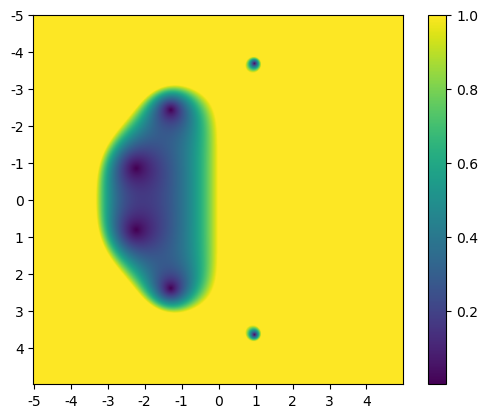

In [112]:
plt.imshow(np.abs(Rz.reshape(500,500)).clip(max=1))
plt.colorbar()
plt.xticks(ticks=np.arange(0, 500, 50), labels=np.arange(-5,5,1));
plt.yticks(ticks=np.arange(0, 500, 50), labels=np.arange(-5,5,1));
#plt.yticks(np.arange(-5, 5, 1))

In [204]:
def RK_stability(A:np.ndarray, b:np.ndarray, err_vec:np.ndarray, grid_size:int=5, pixels:int=500) -> tuple:
    x, y = np.linspace(-grid_size, grid_size, pixels), np.linspace(-grid_size, grid_size, pixels)
    X, Y = np.meshgrid(x, y)
    Z = X + 1j*Y

    absR, absEhat, absEhatmE, absE, absF = [], [], [], [], []
    for z in Z.flatten():
        A_inv_ = np.linalg.solve((np.eye(len(A))-z*A), np.ones(len(b)))
        R = 1+np.inner(z,b.T)@A_inv_
        Ehat = np.inner(z,err_vec.T)@A_inv_
        E = R-np.exp(z)
        absR.append(np.abs(R))
        absEhat.append(np.abs(Ehat))
        absEhatmE.append(np.abs(Ehat-E))
        absE.append(np.abs(E))
        absF.append(np.abs(np.exp(z)))
    absR = np.array(absR).reshape(pixels, pixels)
    absEhat = np.array(absEhat).reshape(pixels, pixels)
    absEhatmE = np.array(absEhatmE).reshape(pixels, pixels)
    absE = np.array(absE).reshape(pixels, pixels)
    absF = np.array(absF).reshape(pixels, pixels)
    
    return absR, absEhat, absEhatmE, absE, absF

def plot_rk_stability(A:np.ndarray, b:np.ndarray, err_vec:np.ndarray, method_name:str=None, grid_size:int=5, pixels:int=500):
    absR, absEhat, absEhatmE, absE, absF = RK_stability(A, b, err_vec, grid_size, pixels)

    fig = plt.figure(figsize=(10,4), dpi=400)
    if method_name!=None:
        fig.suptitle(f"Stability for {method_name}")
    ax1 = plt.subplot2grid(shape=(2, 4), loc=(0, 0), colspan=2, rowspan=2)
    ax2 = plt.subplot2grid(shape=(2, 4), loc=(0, 2))
    ax3 = plt.subplot2grid(shape=(2, 4), loc=(0, 3))
    ax4 = plt.subplot2grid((2, 4), (1, 2))
    ax5 = plt.subplot2grid((2, 4), (1, 3))

    ax1.set_title('$|R(z)|$')
    ax1.imshow(absR.clip(max=1))
    ax1.axvline(pixels//2, color='r')
    ax1.axhline(pixels//2, color='r')
    ax1.set_xticks(ticks=np.arange(0, pixels, 50), labels=np.arange(-grid_size, grid_size,1))
    ax1.set_yticks(ticks=np.arange(0, pixels, 50), labels=np.arange(-grid_size, grid_size,1))
    ax1.set_xlabel("$Re(z)$")
    ax1.set_ylabel("$Im(z)$")

    ax2.set_title('$|\hat{E}(z)|$')
    ax2.set_xticks(ticks=np.arange(0, pixels, 50), labels=[])
    ax2.set_yticks(ticks=np.arange(0, pixels, 50), labels=[])
    ax2.axvline(pixels//2, color='r')
    ax2.axhline(pixels//2, color='r')
    ax2.imshow(absEhat.clip(max=1))

    ax3.set_title('$|exp(z)|$')
    ax3.set_xticks(ticks=np.arange(0, pixels, 50), labels=[])
    ax3.set_yticks(ticks=np.arange(0, pixels, 50), labels=[])
    ax3.axvline(pixels//2, color='r')
    ax3.axhline(pixels//2, color='r')
    ax3.imshow(absF.clip(max=1))
    
    ax4.set_title('$|E(z)|$')
    ax4.set_xticks(ticks=np.arange(0, pixels, 50), labels=[])
    ax4.set_yticks(ticks=np.arange(0, pixels, 50), labels=[])
    ax4.axvline(pixels//2, color='r')
    ax4.axhline(pixels//2, color='r')
    ax4.imshow(absE.clip(max=1))

    ax5.set_title('$|E(z) - \hat{E}(z)|$')
    ax5.set_xticks(ticks=np.arange(0, pixels, 50), labels=[])
    ax5.set_yticks(ticks=np.arange(0, pixels, 50), labels=[])
    ax5.axvline(pixels//2, color='r')
    ax5.axhline(pixels//2, color='r')
    ax5.imshow(absEhatmE.clip(max=1))

    #fig.subplots_adjust(right=0.8, hspace=0.1, wspace=0.1)
    fig.subplots_adjust(hspace=0.25)
    #cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    #fig.colorbar(plt.imshow(absR.clip(max=1)), cax=cbar_ax)
    fig.colorbar(plt.imshow(absE.clip(max=1)), ax=ax1)

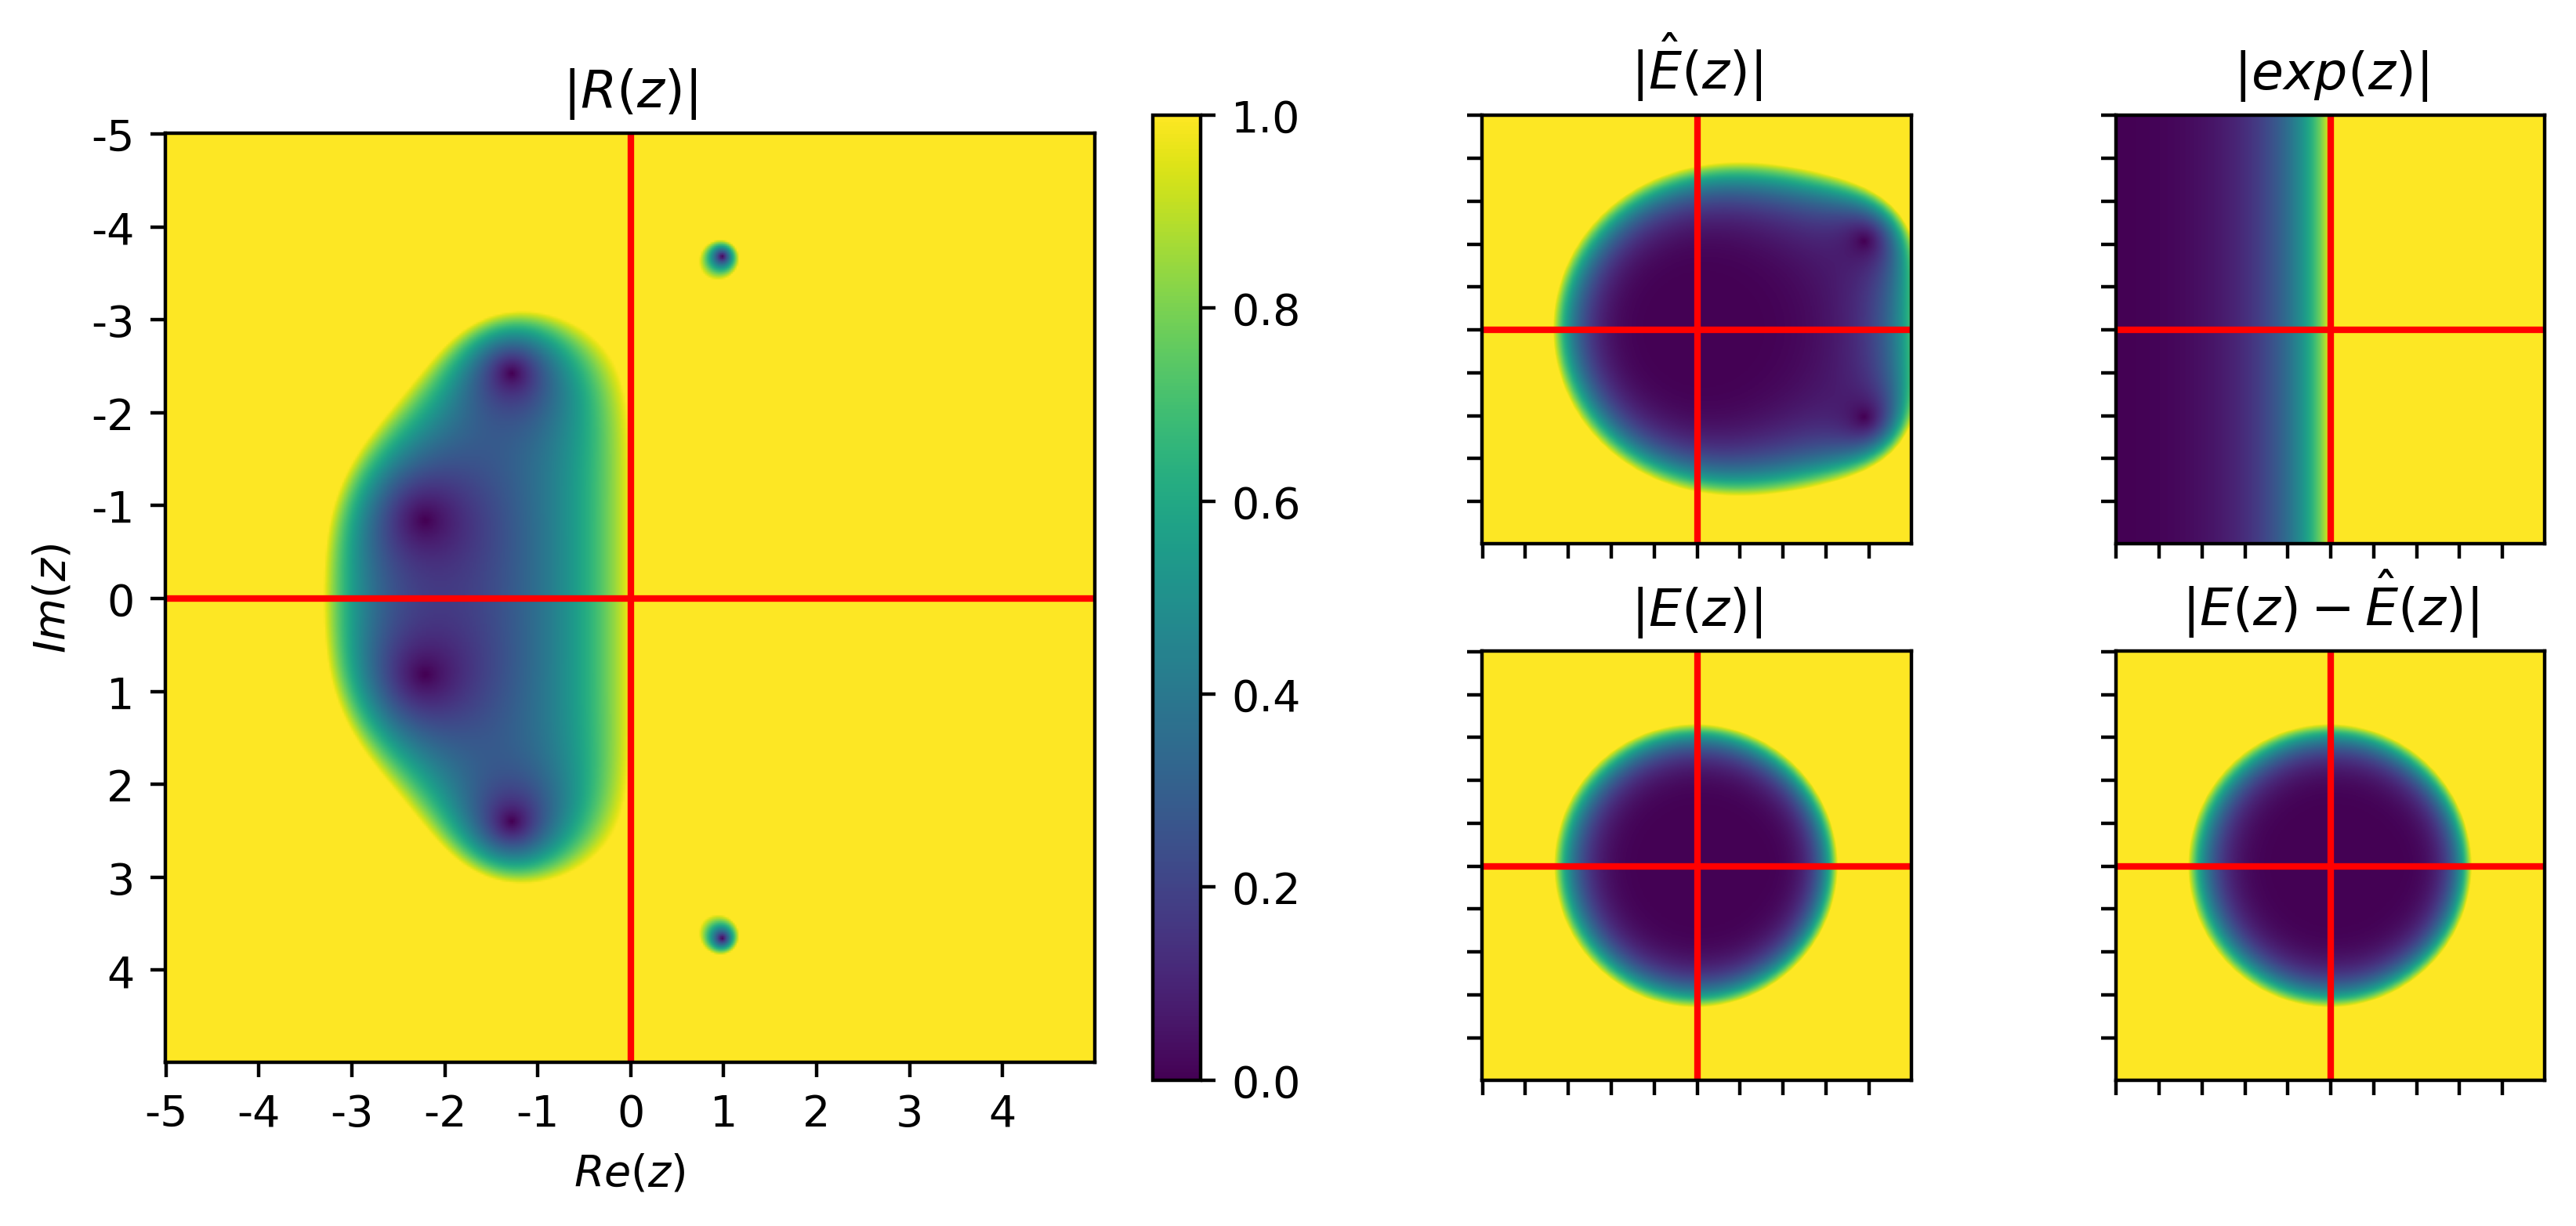

In [206]:
#plot_rk_stability(A, b, e, "DOPRI(5)4")
plot_rk_stability(A, b, e)

### 6.2 Adaptive stepsize implementation

Implementation in ```project.solver_```

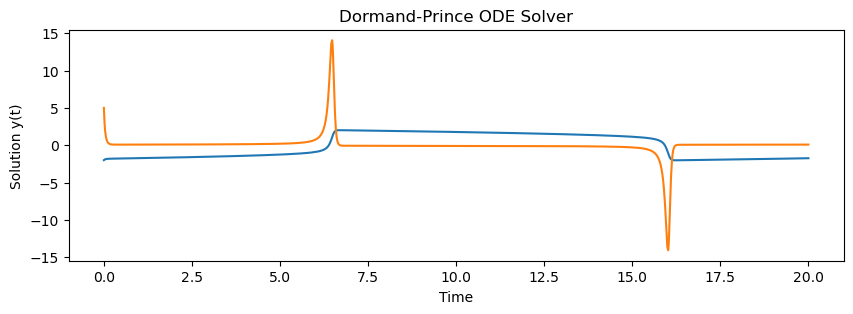

In [3]:
from project.solver_ import DOPRI54
from project.models import VanDerPol
import matplotlib.pyplot as plt

y0 = [-2.0, 5.0]
solver = DOPRI54()
res = solver.integrate(VanDerPol, t0=0, y0=y0, tf=20, controller='predictive')

plt.figure(figsize=(10,3))
plt.plot(res[1]['t'], res[0][:,0])
plt.plot(res[1]['t'], res[0][:,1])
plt.xlabel('Time')
plt.ylabel('Solution y(t)')
plt.title('Dormand-Prince ODE Solver')
plt.show()

### 6.3 DOPRI(5)4 on test problems

We don't need the Jacobians, since DOPRI54 is purely explicit.

In [5]:
from project.solver_ import DOPRI54
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import numpy as np

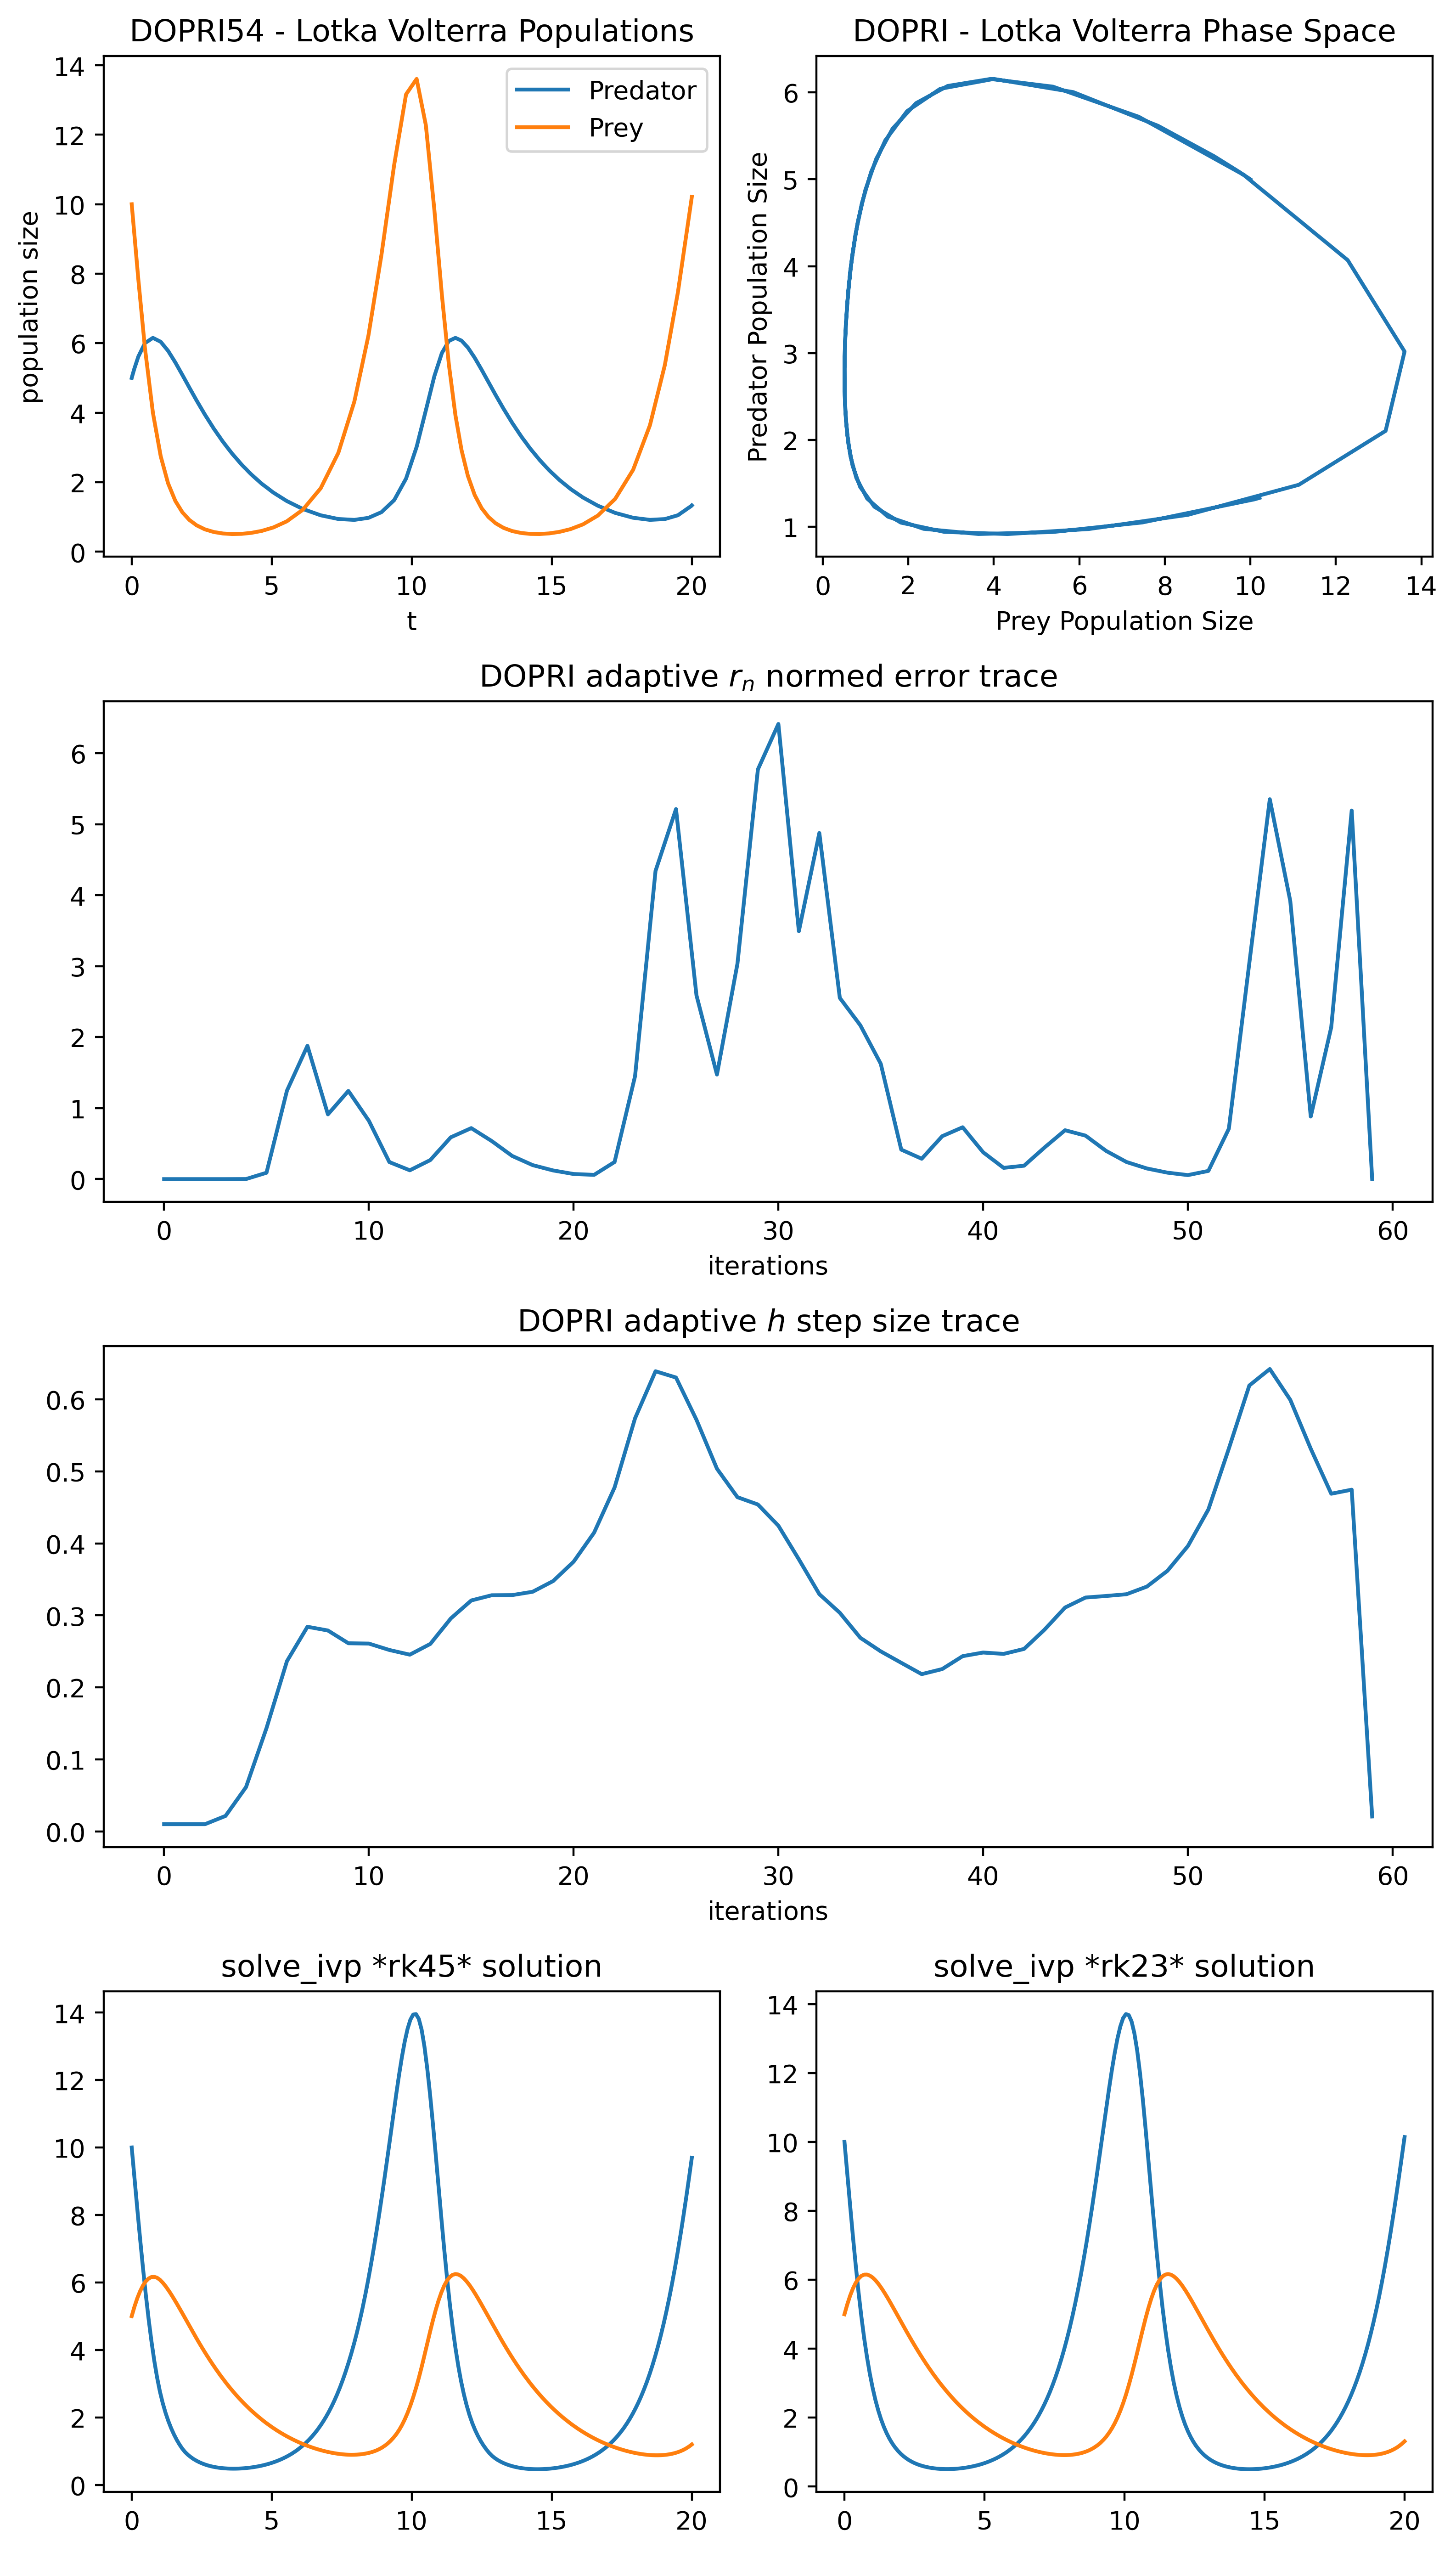

In [10]:
from project.models import LotkaVolterra

y0=[10.0, 5.0]
solver = DOPRI54(h_init=0.01)
res = solver.integrate(LotkaVolterra, t0=0, y0=y0, tf=20)

plt.figure(figsize=(8,14), dpi=400)
plt.subplot(4,2,1)
plt.title('DOPRI54 - Lotka Volterra Populations')
plt.plot(res[1]['t'], res[0][:, 1], label='Predator')
plt.plot(res[1]['t'], res[0][:, 0], label='Prey')
plt.xlabel('t')
plt.ylabel('population size')
plt.legend()

plt.subplot(4,2,2)
plt.title('DOPRI - Lotka Volterra Phase Space')
plt.plot(res[0][:, 0], res[0][:, 1])
plt.xlabel('Prey Population Size')
plt.ylabel('Predator Population Size')

plt.subplot(4,1,2)
plt.title('DOPRI adaptive $r_n$ normed error trace')
plt.plot(res[1]['err_norm'])
plt.xlabel('iterations')

plt.subplot(4,1,3)
plt.title('DOPRI adaptive $h$ step size trace')
plt.plot(res[1]['h'])
plt.xlabel('iterations')

res = solve_ivp(LotkaVolterra, t_span=(0,20), y0=y0, t_eval=np.linspace(0,20,200), method='RK45')
plt.subplot(4,2,7)
plt.title('solve_ivp *rk45* solution')
plt.plot(res.t, res.y[0])
plt.plot(res.t, res.y[1])

res = solve_ivp(LotkaVolterra, t_span=(0,20), y0=y0, t_eval=np.linspace(0,20,200), method='RK23')
plt.subplot(4,2,8)
plt.title('solve_ivp *rk23* solution')
plt.plot(res.t, res.y[0])
plt.plot(res.t, res.y[1])

plt.tight_layout()

*This time with other controller because a bit jittery*

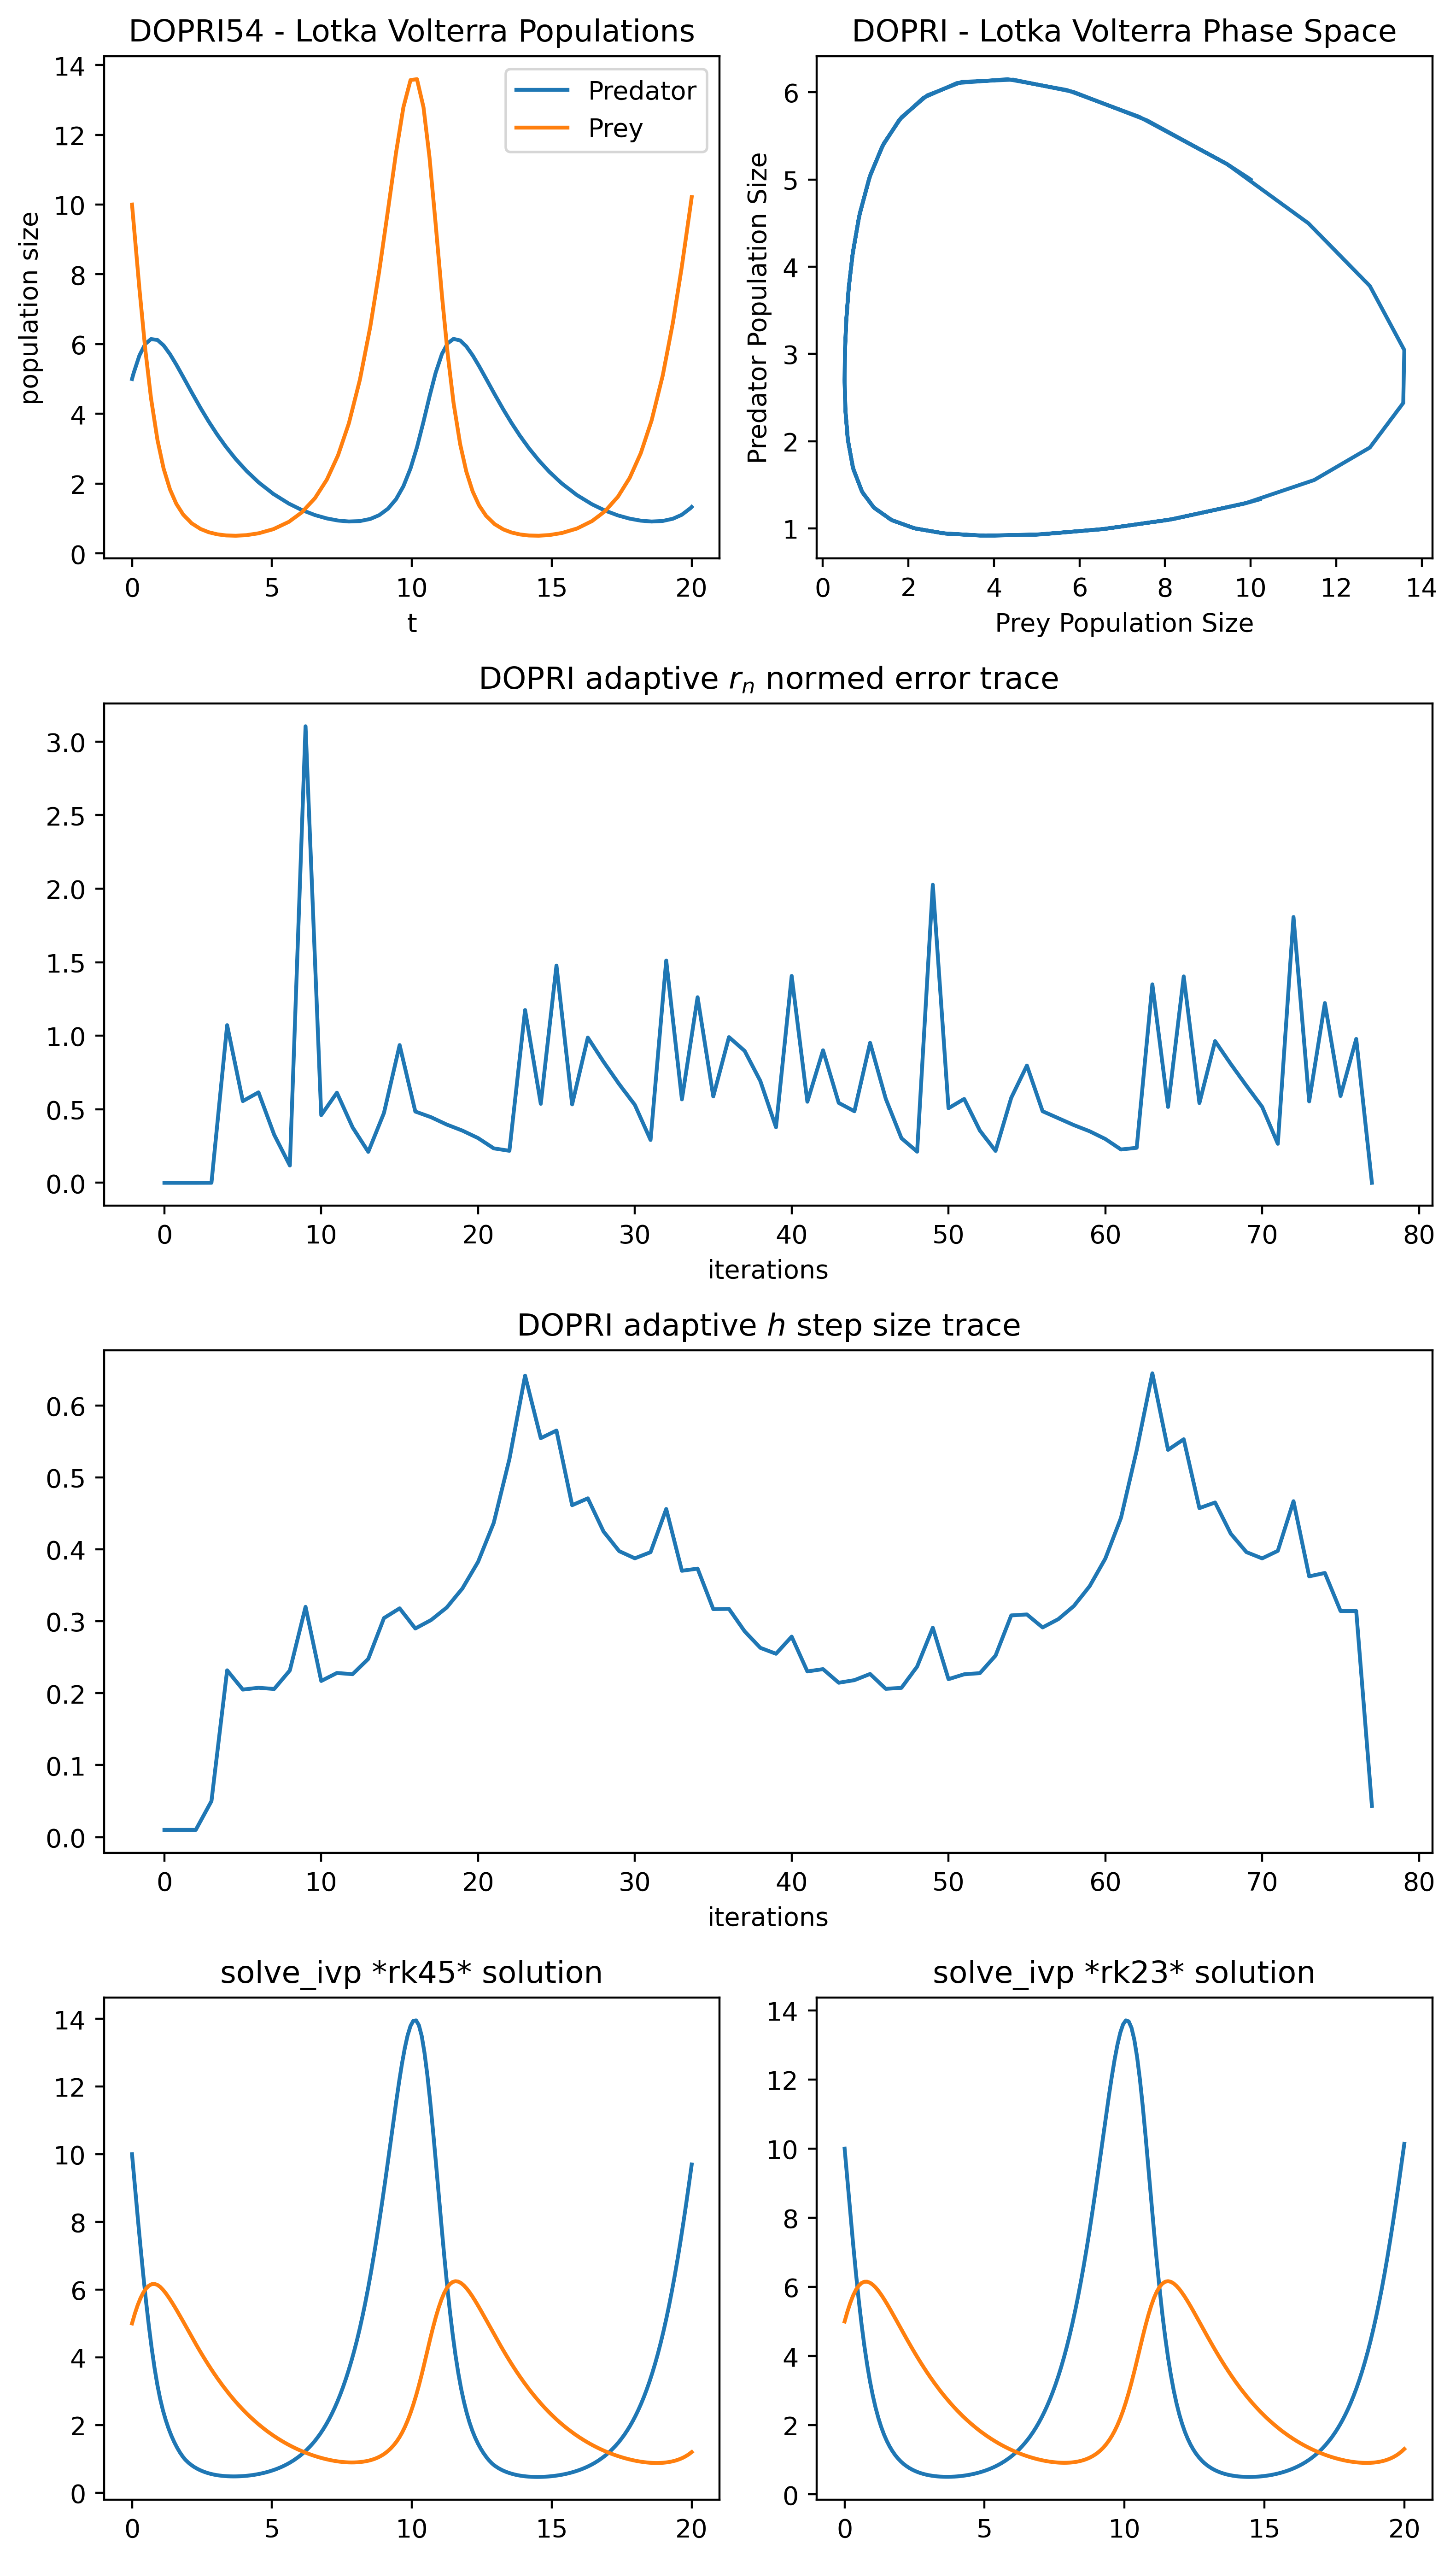

In [14]:
from project.models import LotkaVolterra

y0=[10.0, 5.0]
solver = DOPRI54(h_init=0.01)
res = solver.integrate(LotkaVolterra, t0=0, y0=y0, tf=20, controller='aggressive')

plt.figure(figsize=(8,14), dpi=400)
plt.subplot(4,2,1)
plt.title('DOPRI54 - Lotka Volterra Populations')
plt.plot(res[1]['t'], res[0][:, 1], label='Predator')
plt.plot(res[1]['t'], res[0][:, 0], label='Prey')
plt.xlabel('t')
plt.ylabel('population size')
plt.legend()

plt.subplot(4,2,2)
plt.title('DOPRI - Lotka Volterra Phase Space')
plt.plot(res[0][:, 0], res[0][:, 1])
plt.xlabel('Prey Population Size')
plt.ylabel('Predator Population Size')

plt.subplot(4,1,2)
plt.title('DOPRI adaptive $r_n$ normed error trace')
plt.plot(res[1]['err_norm'])
plt.xlabel('iterations')

plt.subplot(4,1,3)
plt.title('DOPRI adaptive $h$ step size trace')
plt.plot(res[1]['h'])
plt.xlabel('iterations')

res = solve_ivp(LotkaVolterra, t_span=(0,20), y0=y0, t_eval=np.linspace(0,20,200), method='RK45')
plt.subplot(4,2,7)
plt.title('solve_ivp *rk45* solution')
plt.plot(res.t, res.y[0])
plt.plot(res.t, res.y[1])

res = solve_ivp(LotkaVolterra, t_span=(0,20), y0=y0, t_eval=np.linspace(0,20,200), method='RK23')
plt.subplot(4,2,8)
plt.title('solve_ivp *rk23* solution')
plt.plot(res.t, res.y[0])
plt.plot(res.t, res.y[1])

plt.tight_layout()

### 6.3.2 Van der Pol

DORPI54 step_evals 346
RK45 step_evals 914
RK23 step_evals 905


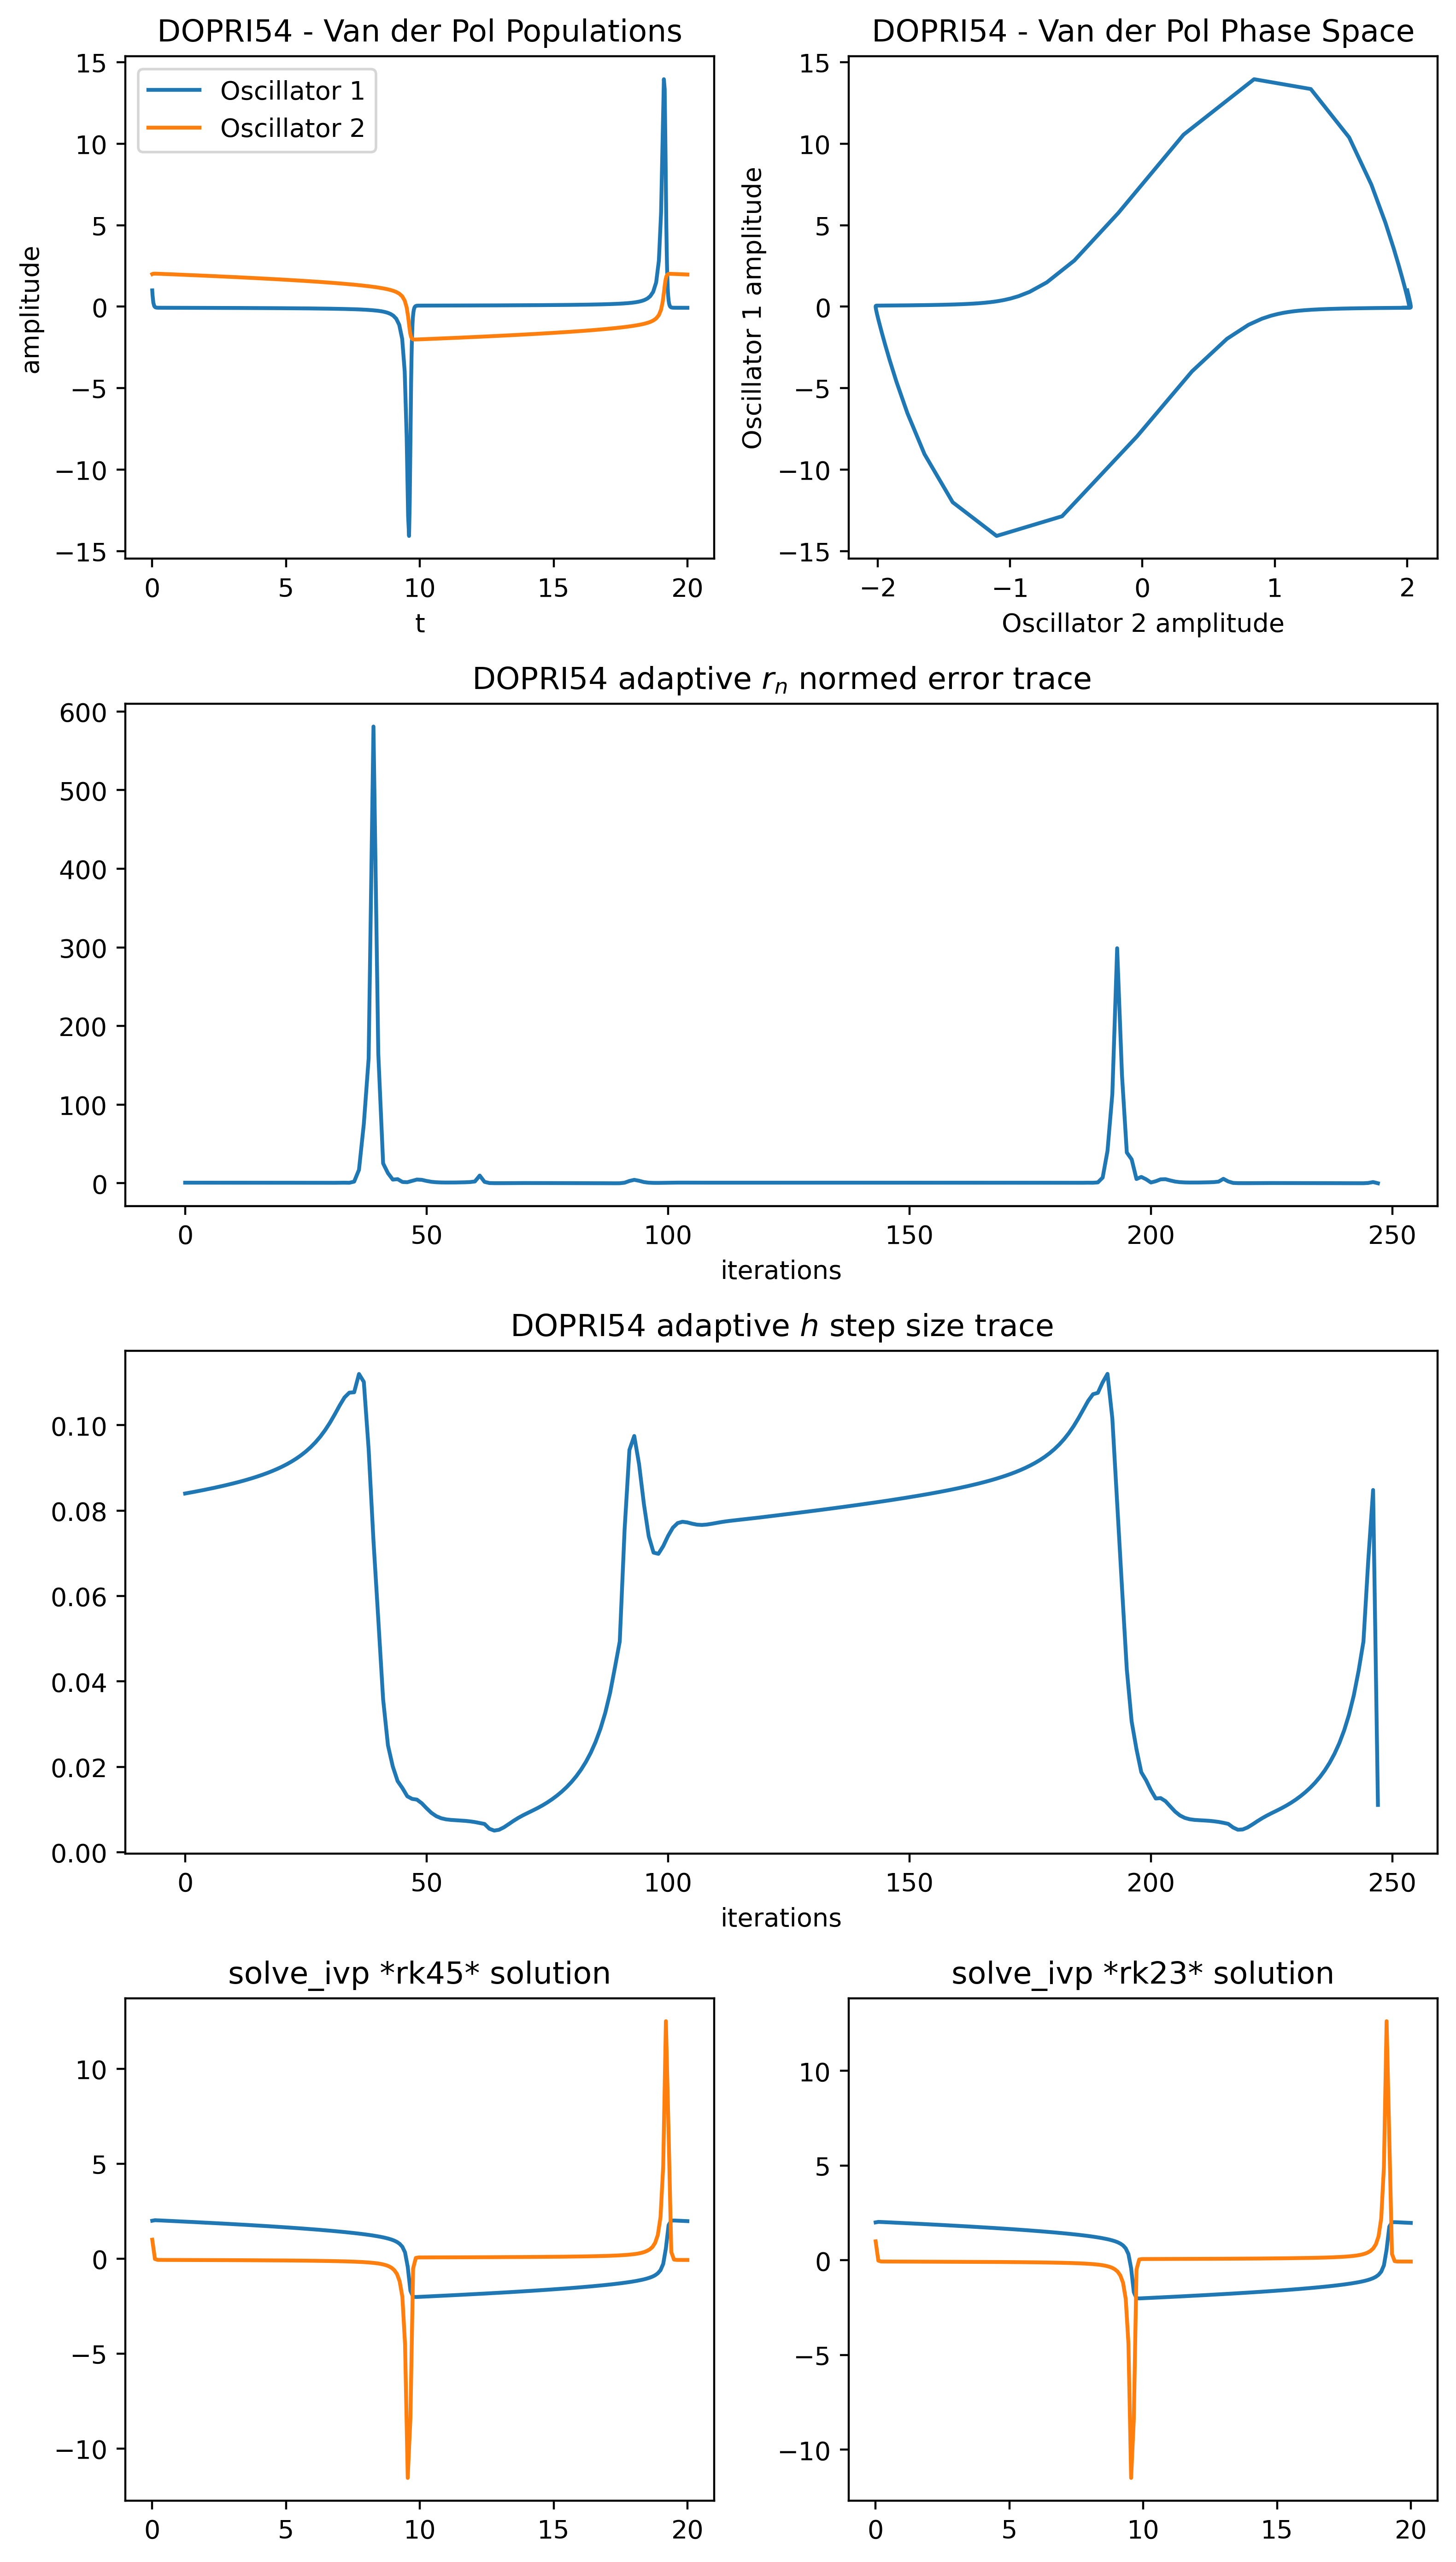

In [17]:
from project.models import VanDerPol

y0=[2.0, 1.0]
solver = DOPRI54()
res = solver.integrate(VanDerPol, t0=0, y0=y0, tf=20)
print("DORPI54 step_evals", res[1]['step_evals'])

plt.figure(figsize=(8,14), dpi=400)
plt.subplot(4,2,1)
plt.title('DOPRI54 - Van der Pol Populations')
plt.plot(res[1]['t'], res[0][:, 1], label='Oscillator 1')
plt.plot(res[1]['t'], res[0][:, 0], label='Oscillator 2')
plt.xlabel('t')
plt.ylabel('amplitude')
plt.legend()

plt.subplot(4,2,2)
plt.title('DOPRI54 - Van der Pol Phase Space')
plt.plot(res[0][:, 0], res[0][:, 1])
plt.xlabel('Oscillator 2 amplitude')
plt.ylabel('Oscillator 1 amplitude')

plt.subplot(4,1,2)
plt.title('DOPRI54 adaptive $r_n$ normed error trace')
plt.plot(res[1]['err_norm'][100:]) # added burn-in
plt.xlabel('iterations')

plt.subplot(4,1,3)
plt.title('DOPRI54 adaptive $h$ step size trace')
plt.plot(res[1]['h'][100:])
plt.xlabel('iterations')

res = solve_ivp(VanDerPol, t_span=(0,20), y0=y0, t_eval=np.linspace(0,20,200), method='RK45')
print("RK45 step_evals", res.nfev)
plt.subplot(4,2,7)
plt.title('solve_ivp *rk45* solution')
plt.plot(res.t, res.y[0])
plt.plot(res.t, res.y[1])

res = solve_ivp(VanDerPol, t_span=(0,20), y0=y0, t_eval=np.linspace(0,20,200), method='RK23')
print("RK23 step_evals", res.nfev)
plt.subplot(4,2,8)
plt.title('solve_ivp *rk23* solution')
plt.plot(res.t, res.y[0])
plt.plot(res.t, res.y[1])

plt.tight_layout()

### 6.3.3 CSTR3

DORPI54 step_evals 12591
RK45 step_evals 83834
BDF step_evals 284


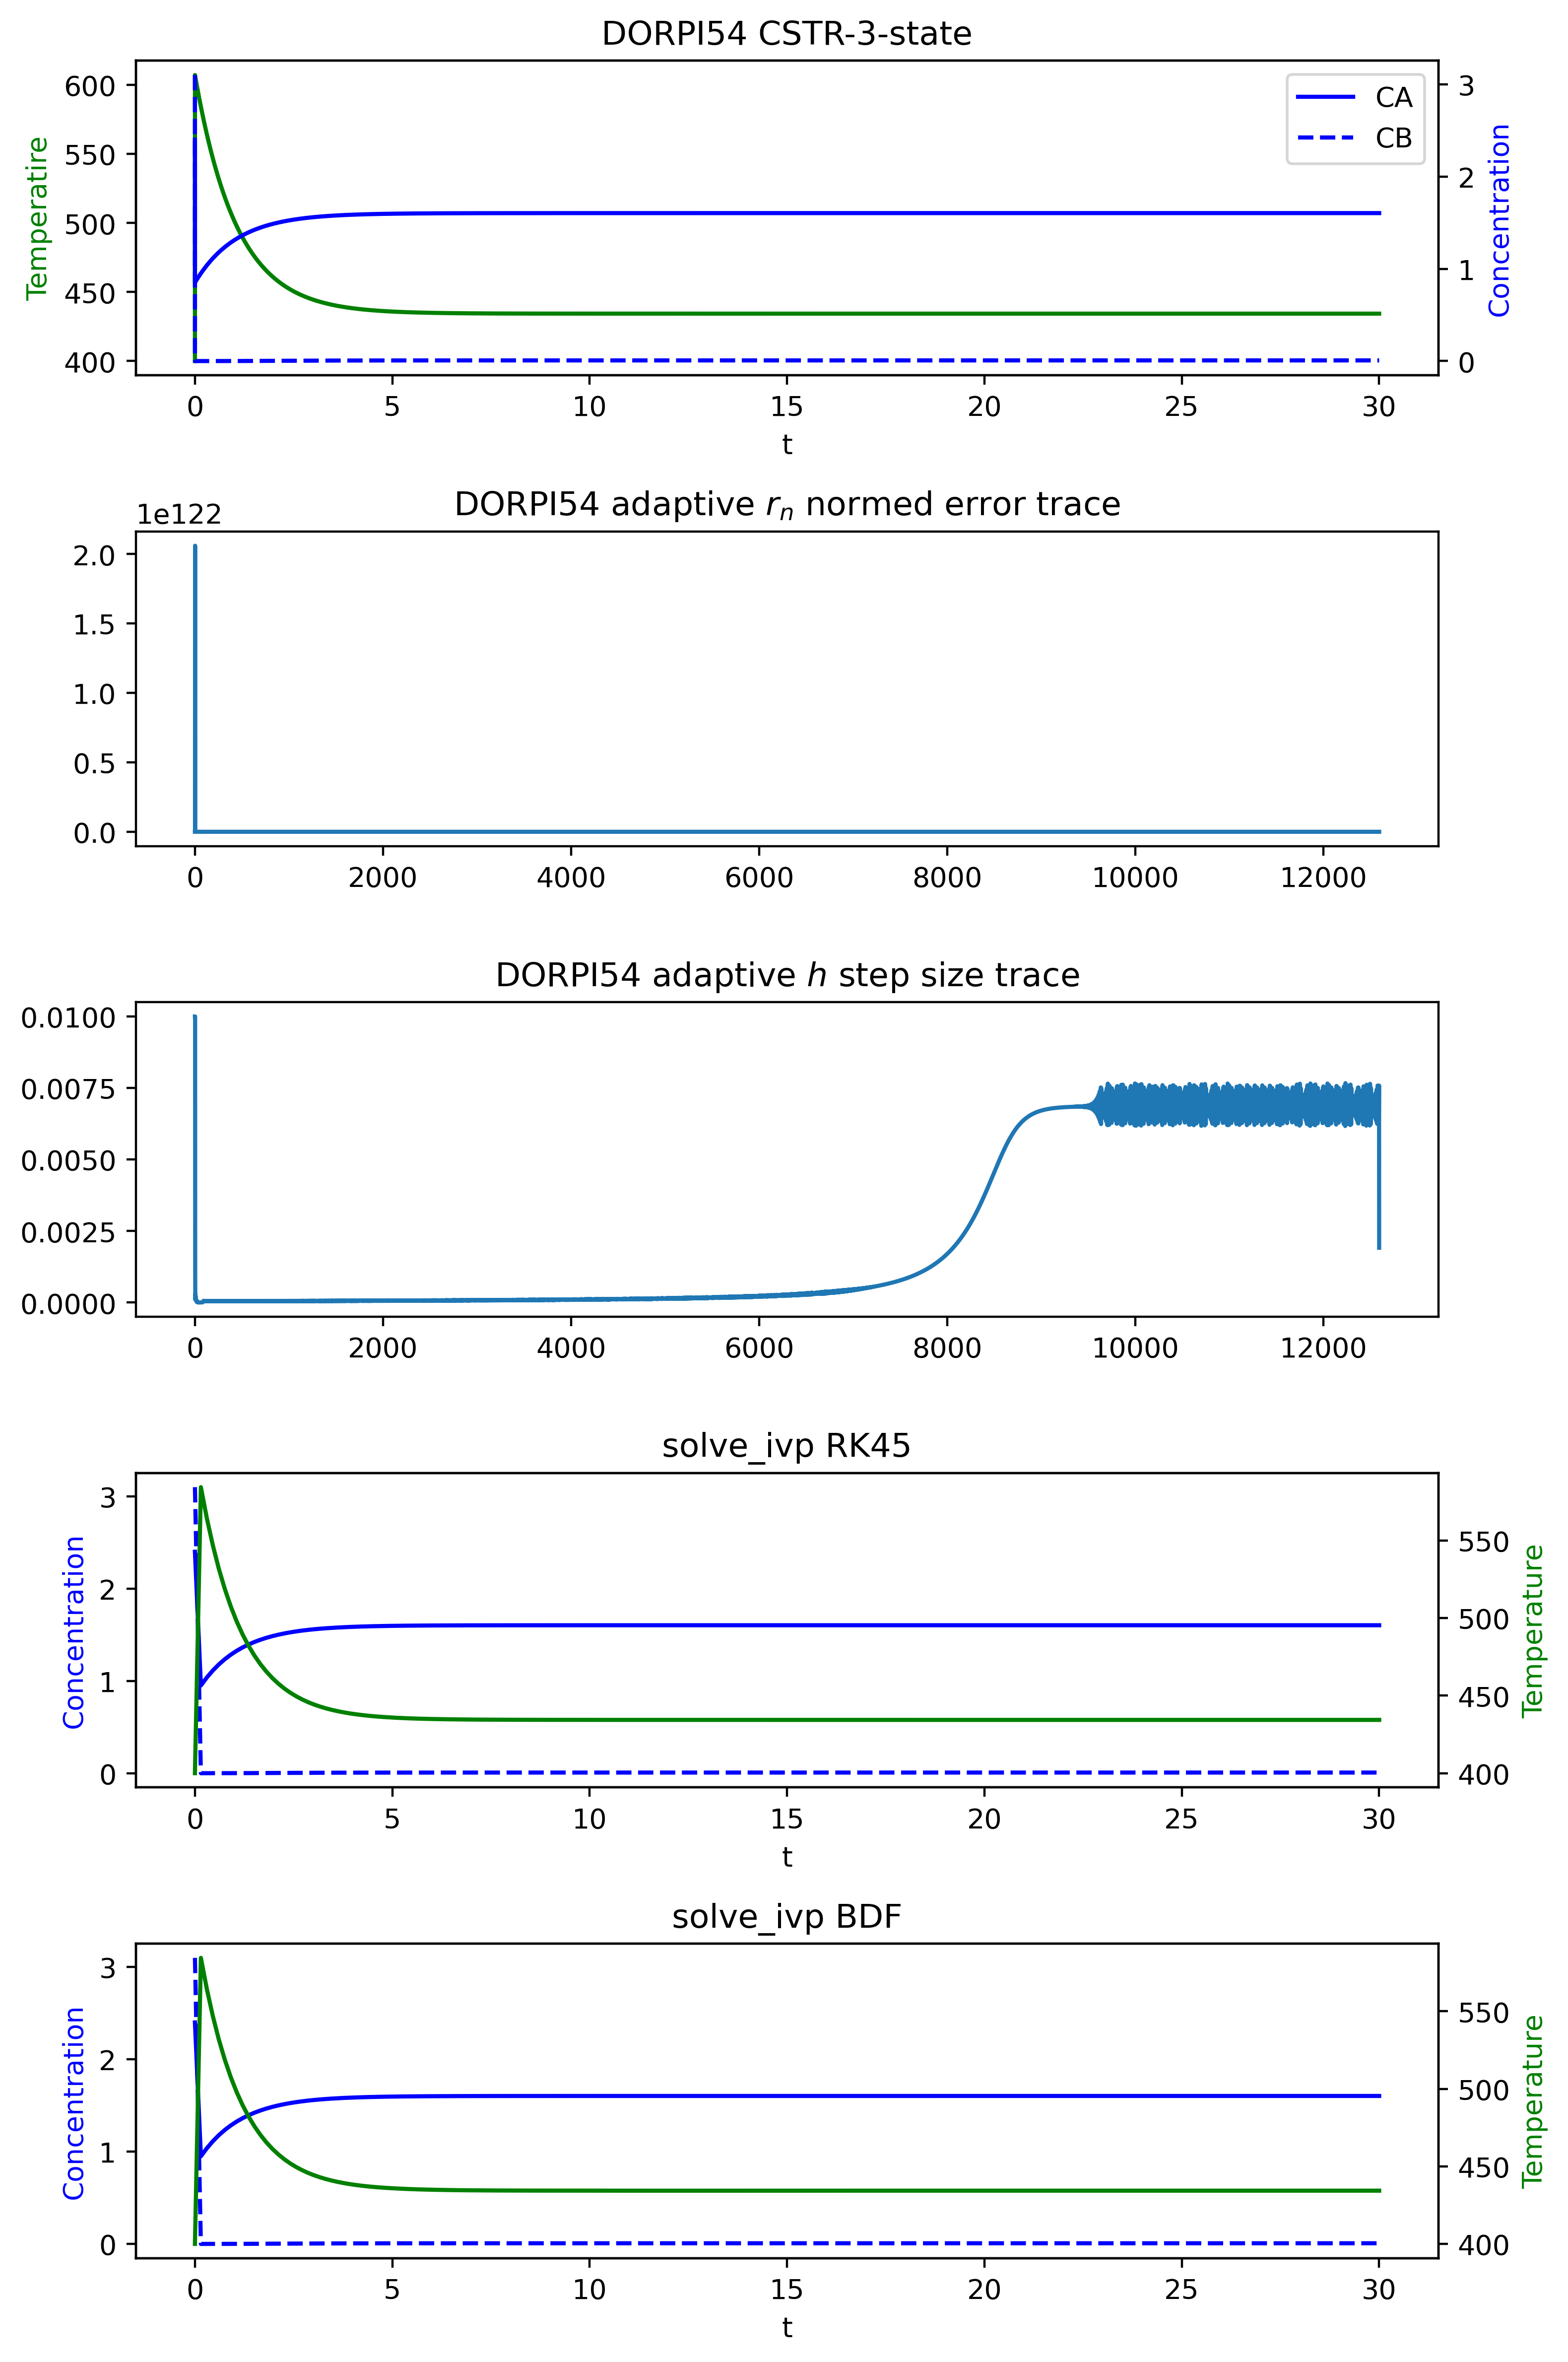

In [7]:
from project.models import CSTR3
from scipy.integrate import solve_ivp

#C0 = np.array([1.6/2, 2.4/2, 600]) 
#C0 = np.array([2.4, 4.1, 300]) #-> works!
#C0 = np.array([0.4, 3.1, 350]) #-> works!
#C0 = np.array([2.4, 3.1, 200]) #-> works!
C0 = np.array([2.4, 3.1, 400]) #-> works!
#C0 = np.array([1.4, 3.7, 200]) #-> works!
solver = DOPRI54()
res = solver.integrate(CSTR3, t0=0, y0=C0, tf=30, controller='aggressive')
print("DORPI54 step_evals", res[1]['step_evals'])

fig, [ax1, ax3, ax4, ax5, ax7] = plt.subplots(nrows=5, ncols=1, figsize=(8,12), dpi=400)

ax1.set_title("DORPI54 CSTR-3-state")
ax1.plot(res[1]['t'], res[0][:,2], 'g-')
ax2 = ax1.twinx()
ax2.plot(res[1]['t'], res[0][:,0], 'b', linestyle='-', label='CA')
ax2.plot(res[1]['t'], res[0][:,1], 'b', linestyle='--', label='CB')

ax1.set_xlabel('t')
ax1.set_ylabel('Temperatire', color='g')
ax2.set_ylabel('Concentration', color='b')
ax2.grid(False)
ax2.legend()

ax3.set_title('DORPI54 adaptive $r_n$ normed error trace')
ax3.plot(res[1]['err_norm'])

ax4.set_title('DORPI54 adaptive $h$ step size trace')
ax4.plot(res[1]['h'])

res = solve_ivp(CSTR3, t_span=(0,30), y0=C0, t_eval=np.linspace(0,30,200), method='RK45')
print("RK45 step_evals", res.nfev)
ax5.set_title("solve_ivp RK45")
ax5.plot(res.t, res.y[0], 'b', linestyle='-', label='CA')
ax5.plot(res.t, res.y[1], 'b', linestyle='--', label='CB')
ax5.set_ylabel('Concentration', color='b')
ax5.set_xlabel('t')
ax6 = ax5.twinx()
ax6.plot(res.t, res.y[2], 'g-', label='Temperature')
ax6.grid(False)
ax6.set_ylabel('Temperature', color='g')

res = solve_ivp(CSTR3, t_span=(0,30), y0=C0, t_eval=np.linspace(0,30,200), method='BDF')
print("BDF step_evals", res.nfev)
ax7.set_title("solve_ivp BDF")
ax7.plot(res.t, res.y[0], 'b', linestyle='-', label='CA')
ax7.plot(res.t, res.y[1], 'b', linestyle='--', label='CB')
ax7.set_ylabel('Concentration', color='b')
ax7.set_xlabel('t')
ax8 = ax7.twinx()
ax8.plot(res.t, res.y[2], 'g-', label='Temperature')
ax8.grid(False)
ax8.set_ylabel('Temperature', color='g')

plt.tight_layout()

- Checking the amount of function evals, my implementation has always been the most efficient for non-stiff conditions
- However, when having stiff conditions, the BDF handles it better. C0 = np.array([0.4, 3.1, 350])
- For conditions #C0 = np.array([2.4, 3.1, 400]) most controllers fail...only 'aggressive' works! and more efficient than RK45, fewer function evals, but still more than BDF

DOPRI54 does not handle 0 conditions or oscillations well.

### 6.3.4 CSTR1

In [8]:
from project.models import CSTR1
from project.solver_ import DOPRI54
import matplotlib.pyplot as plt
import numpy as np

# T0 = 273.15 -> works
T0 = 239.0
solver = DOPRI54(h_init=0.01)
res = solver.integrate(CSTR1, t0=0, y0=[T0,], tf=20, controller='pid')

plt.figure(figsize=(8,14), dpi=400)
plt.subplot(4,2,1)
plt.title('DOPRI54 - CSTR1 Temperature')
plt.plot(res[1]['t'], res[0][:, 0])
plt.xlabel('t')
plt.ylabel('Temperature')

plt.subplot(4,2,2)
plt.title('DOPRI54 - CSTR1 1D Linear Phase Space')
plt.plot(res[0][:, 0], res[0][:, 0])
plt.xlabel('Temperature')
plt.ylabel('Temperature')

plt.subplot(4,1,2)
plt.title('DOPRI54 adaptive $r_n$ normed error trace')
plt.plot(res[1]['err_norm'][100:]) # added burn-in
plt.xlabel('iterations')

plt.subplot(4,1,3)
plt.title('DOPRI54 adaptive $h$ step size trace')
plt.plot(res[1]['h'][100:])
plt.xlabel('iterations')

res = solve_ivp(CSTR1, t_span=(0,20), y0=y0, t_eval=np.linspace(0,20,200), method='RK45')
plt.subplot(4,2,7)
plt.title('solve_ivp RK45 solution')
plt.plot(res.t, res.y[0])
plt.plot(res.t, res.y[1])

res = solve_ivp(CSTR1, t_span=(0,20), y0=y0, t_eval=np.linspace(0,20,200), method='RK23')
plt.subplot(4,2,8)
plt.title('solve_ivp RK23 solution')
plt.plot(res.t, res.y[0])
plt.plot(res.t, res.y[1])

plt.tight_layout()

RuntimeError: DOPRI54 integration step failed at t=0 with h=0.01: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (7,) + inhomogeneous part.